In [1]:
## Get dependencies ##

import numpy as np
import string
import math
import sys
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sn
sys.path.append('..')
from GIR import *
import scipy as sp
import pickle
import time
import scipy as sp
from scipy import ndimage
from scipy import signal
import os
import statsmodels.api as sm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import glob
import requests
import ftplib
import PyPDF2
import io
import cmocean
import multiprocessing

import xarray as xr

xr.set_options(display_style='html')

def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()
    
## Matplotlib rcparams setup:

matplotlib.rcParams['font.family']='Helvetica'
matplotlib.rcParams['font.size']=11
# matplotlib.rcParams['font.weight']=400

matplotlib.rcParams['image.cmap']='cmo.ice'

matplotlib.rcParams['axes.prop_cycle']=matplotlib.cycler('color',['011936','FF7D00','225560','BFACAA','D72638','788C9B','A33F00','7CAAB0','685655','EB767C'])
matplotlib.rcParams['axes.formatter.limits']=-3,3
matplotlib.rcParams['axes.labelweight']=300

matplotlib.rcParams['legend.frameon']=False

matplotlib.rcParams['boxplot.whiskers']=(5,95)
matplotlib.rcParams['boxplot.showfliers']=False
matplotlib.rcParams['boxplot.showfliers']=False
matplotlib.rcParams['boxplot.medianprops.color']='black'

matplotlib.rcParams['errorbar.capsize']=5

matplotlib.rcParams['hist.bins']='auto'

plt.rcParams['pdf.fonttype'] = 42

%matplotlib inline

In [2]:
from abrupt_response_fit import *

In [3]:
# datasets = pd.read_pickle('cmip6_abrupt4xco2_temp.csv')
abrupt4x_tas_df = pd.read_csv('./cmip6_data/abrupt-4xCO2_tas.csv',index_col=0)
abrupt4x_rlut_df = pd.read_csv('./cmip6_data/abrupt-4xCO2_rlut.csv',index_col=0)
abrupt4x_rsut_df = pd.read_csv('./cmip6_data/abrupt-4xCO2_rsut.csv',index_col=0)
abrupt4x_rsdt_df = pd.read_csv('./cmip6_data/abrupt-4xCO2_rsdt.csv',index_col=0)
piControl_tas_df = pd.read_csv('./cmip6_data/piControl_tas.csv',index_col=0)
piControl_rlut_df = pd.read_csv('./cmip6_data/piControl_rlut.csv',index_col=0)
piControl_rsut_df = pd.read_csv('./cmip6_data/piControl_rsut.csv',index_col=0)
piControl_rsdt_df = pd.read_csv('./cmip6_data/piControl_rsdt.csv',index_col=0)

In [39]:
abrupt4x_tas_anom_df = abrupt4x_tas_df.copy()
abrupt4x_EB_anom_df = abrupt4x_rsdt_df - (abrupt4x_rlut_df + abrupt4x_rsut_df)

for ism in abrupt4x_tas_anom_df.columns:
    if ism in piControl_tas_df.columns:
        abrupt4x_tas_anom_df.loc[:,ism] -= piControl_tas_df.loc[:,ism].dropna().iloc[-50:].mean()
    elif ism.split('_')[1] in [x.split('_')[1] for x in piControl_tas_df.columns]:
        ism_alt = [x for x in piControl_tas_df.columns if x.split('_')[1]==ism.split('_')[1]]
        piControl_mean = piControl_tas_df.loc[:,sorted(ism_alt)[0]].dropna().iloc[-50:].mean()
        abrupt4x_tas_anom_df.loc[:,ism] -= piControl_mean
    else:
        abrupt4x_tas_anom_df.loc[:,ism] = np.nan
        print(ism+' not in piControl tas!')
        
for ism in abrupt4x_EB_anom_df.columns:
    if ism in ['NCAR_CESM2_r1i1p1f1','MOHC_HadGEM3-GC31-MM_r1i1p1f3']:
        continue # these two have weird piControl TOA EB
    if ism in piControl_rlut_df.columns:
        abrupt4x_EB_anom_df.loc[:,ism] -= (piControl_rsdt_df - (piControl_rlut_df + piControl_rsut_df)).loc[:,ism].dropna().iloc[-50:].mean()
    elif ism.split('_')[1] in [x.split('_')[1] for x in piControl_rlut_df.columns]:
        ism_alt = [x for x in piControl_rlut_df.columns if x.split('_')[1]==ism.split('_')[1]]
        piControl_mean = (piControl_rsdt_df - (piControl_rlut_df + piControl_rsut_df)).loc[:,sorted(ism_alt)[0]].dropna().iloc[-50:].mean()
        abrupt4x_EB_anom_df.loc[:,ism] -= piControl_mean
    else:
        abrupt4x_EB_anom_df.loc[:,ism] = np.nan
        print(ism+' not in piControl rad!')

In [43]:
def fit_ism(ism,method,nfev):
    print('fitting '+ism)
    data = np.array([abrupt4x_tas_anom_df[ism].dropna().values,abrupt4x_EB_anom_df[ism].dropna().values])
    if data.shape[1] > 30 and data[0].mean()<50 and data[1].mean()>0:
        fit = fit_model(data,method,nfev)
        return fit
    else:
        print(ism + ' data not clean')
        return None

In [6]:
P1=multiprocessing.Pool(processes=8)
CMIP6_response_params = P1.starmap(fit_ism,[(x,None,20000) for x in abrupt4x_tas_anom_df.columns])
P1.close()

fitting CNRM-CERFACS_CNRM-ESM2-1_r3i1p1f2
fitting NASA-GISS_GISS-E2-1-G_r1i1p1f3
fitting IPSL_IPSL-CM6A-LR_r3i1p1f1
fitting MRI_MRI-ESM2-0_r6i1p1f1
fitting IPSL_IPSL-CM6A-LR_r2i1p1f1
fitting MRI_MRI-ESM2-0_r3i1p1f1
IPSL_IPSL-CM6A-LR_r3i1p1f1 data not clean
IPSL_IPSL-CM6A-LR_r2i1p1f1 data not clean
MRI_MRI-ESM2-0_r3i1p1f1 data not clean
MRI_MRI-ESM2-0_r6i1p1f1 data not clean
fitting CCCma_CanESM5_r1i1p1f1
fitting E3SM-Project_E3SM-1-0_r1i1p1f1
fitting IPSL_IPSL-CM6A-LR_r6i1p1f1
fitting CNRM-CERFACS_CNRM-CM6-1_r3i1p1f2
CNRM-CERFACS_CNRM-CM6-1_r3i1p1f2 data not clean
IPSL_IPSL-CM6A-LR_r6i1p1f1 data not clean
fitting MPI-M_MPI-ESM1-2-HR_r1i1p1f1
fitting IPSL_IPSL-CM6A-LR_r9i1p1f1
E3SM-Project_E3SM-1-0_r1i1p1f1 data not clean
IPSL_IPSL-CM6A-LR_r9i1p1f1 data not clean
fitting NOAA-GFDL_GFDL-CM4_r1i1p1f1
fitting IPSL_IPSL-CM6A-LR_r10i1p1f1
IPSL_IPSL-CM6A-LR_r10i1p1f1 data not clean
fitting CSIRO_ACCESS-ESM1-5_r1i1p1f1
fitting MRI_MRI-ESM2-0_r1i2p1f1
fitting CCCma_CanESM5_r1i1p2f1
fit converge

In [7]:
dict_res = dict(zip([abrupt4x_EB_anom_df.columns[i] for i,v in enumerate(CMIP6_response_params) if not v is None],[v for i,v in enumerate(CMIP6_response_params) if not v is None]))

In [8]:
res_df = pd.DataFrame(dict_res,index = ['gamma', 'C1', 'C2', 'C3', 'kap1', 'kap2', 'kap3', 'epsilon', 'stds', 'stdx','F_4x'])
# res_df.loc['success'] = [v.success for i,v in enumerate(res) if v != None]

In [50]:
res_df.to_csv('../Parameter_Sets/CMIP6_stoch_Geoffrey_response.csv')

In [47]:
fair_params = pd.concat([convert_geoffrey_to_FaIR(x) for y,x in res_df.iteritems()],axis=1,keys=res_df.columns)

In [151]:
fair_params_reshape = fair_params.unstack().reset_index()
fair_params_reshape.loc[:,'level_3'] = fair_params_reshape.level_2 + fair_params_reshape.level_1.astype(str)
fair_params_reshape = fair_params_reshape.set_index(['level_0','level_3']).iloc[:,-1].unstack().T

In [188]:
## take the model parameter values to be the average of all the individual members

fair_params_reshape_1 = pd.DataFrame(index=fair_params_reshape.index)

model_list = list(set(['_'.join(x.split('_')[:2]) for x in fair_params_reshape.columns]))
for model in model_list:
    fair_params_reshape_1.loc[:,model] = fair_params_reshape.loc[:,[x for x in fair_params_reshape.columns if model.split('_')[1] == x.split('_')[1]]].mean(axis=1)
    
for i in [1,2,3]:
    fair_params_reshape_1.loc['q'+str(i)+'d'+str(i)] = fair_params_reshape_1.loc['q'+str(i)]*fair_params_reshape_1.loc['d'+str(i)]

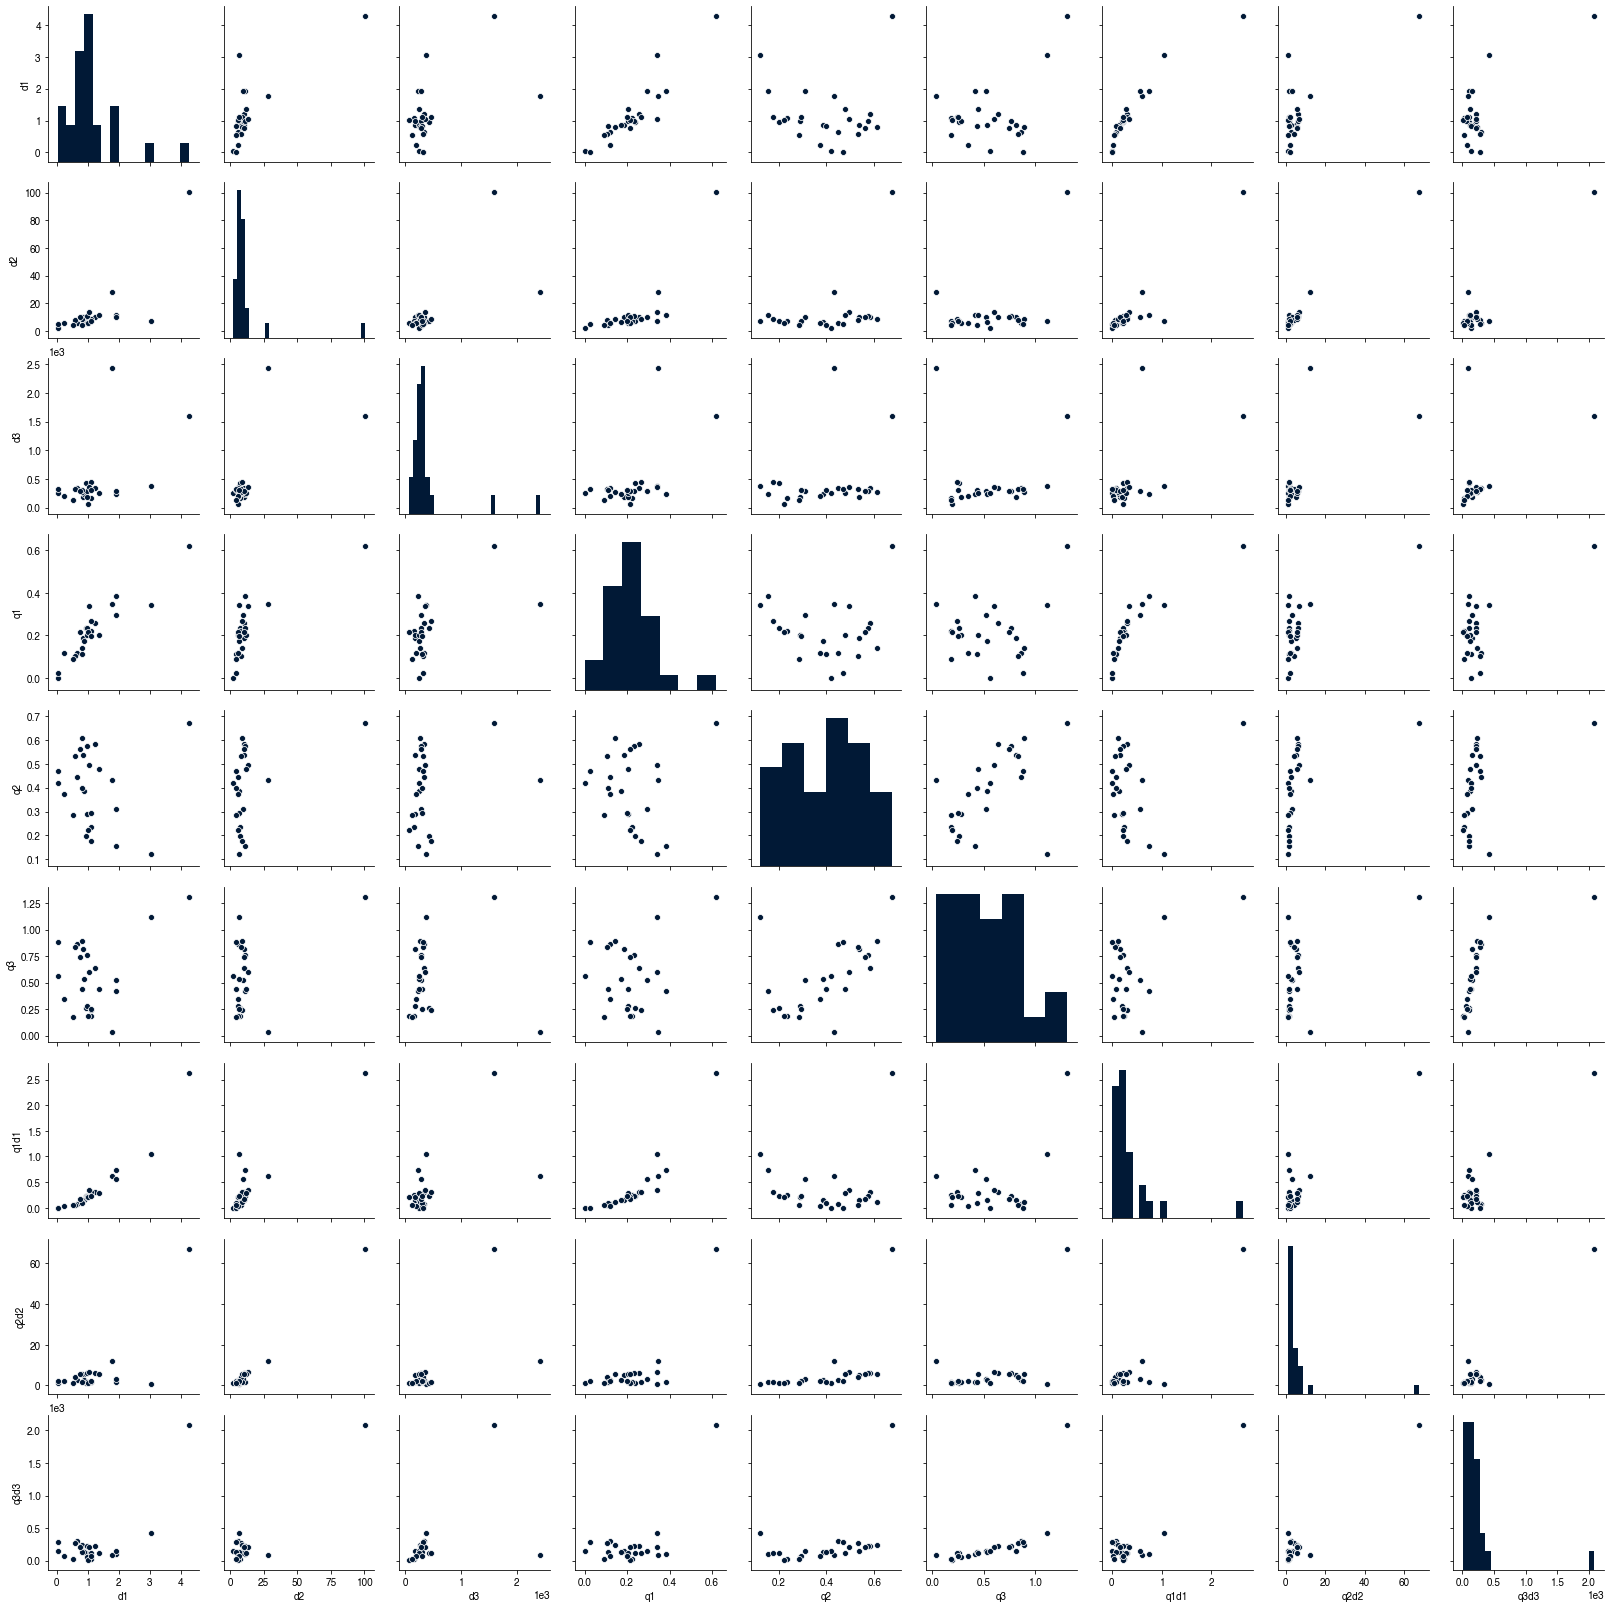

In [210]:
sn.pairplot(fair_params_reshape_1.T)

In [137]:
# models = sorted(list(fair_params.columns.levels[0]))

fair_forc = return_empty_forcing(start_year=0,end_year=1000,scen_names=res_df.columns)
for ism in res_df.columns:
    fair_forc[ism] = res_df.loc['F_4x',ism]
    
GIR_abrupt_4x = run_GIR(emissions_in=return_empty_emissions(fair_forc),forcing_in=fair_forc,thermal_parameters=fair_params)

Integrating 38 scenarios, 1 gas cycle parameter sets, 1 independent thermal response parameter sets, over ['CH4', 'CO2', 'N2O'], between 0.0 and 1000.0...


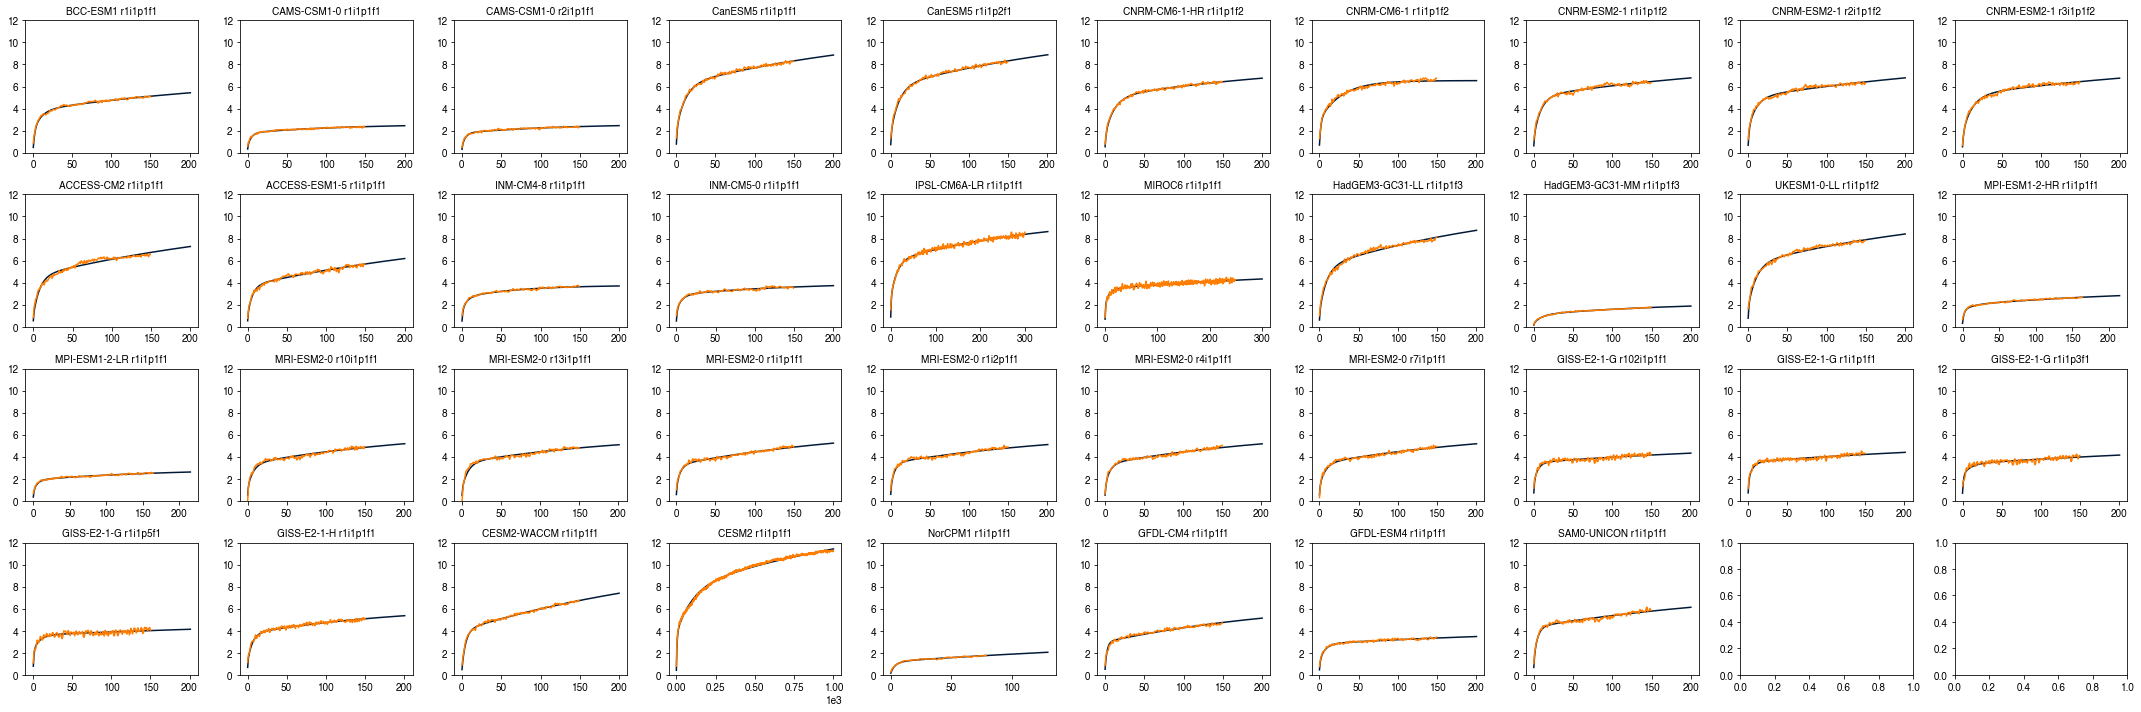

In [61]:
fig,ax = plt.subplots(4,10,figsize=(30,10))

for i,a in enumerate(ax.flatten()[:-2]):
    ism = GIR_abrupt_4x['T'].columns.levels[0][i]
    a.plot(GIR_abrupt_4x['T'].loc[0:abrupt4x_tas_anom_df.loc[:,ism].dropna().size+50,ism].values)
    a.plot(abrupt4x_tas_anom_df.loc[:,ism].dropna().values)
    a.set_title(' '.join(ism.split('_')[1:]),fontsize=10)
#     a.set_xlim(0,1000)
    a.set_ylim(0,12)
    
plt.tight_layout()

(0, 12)

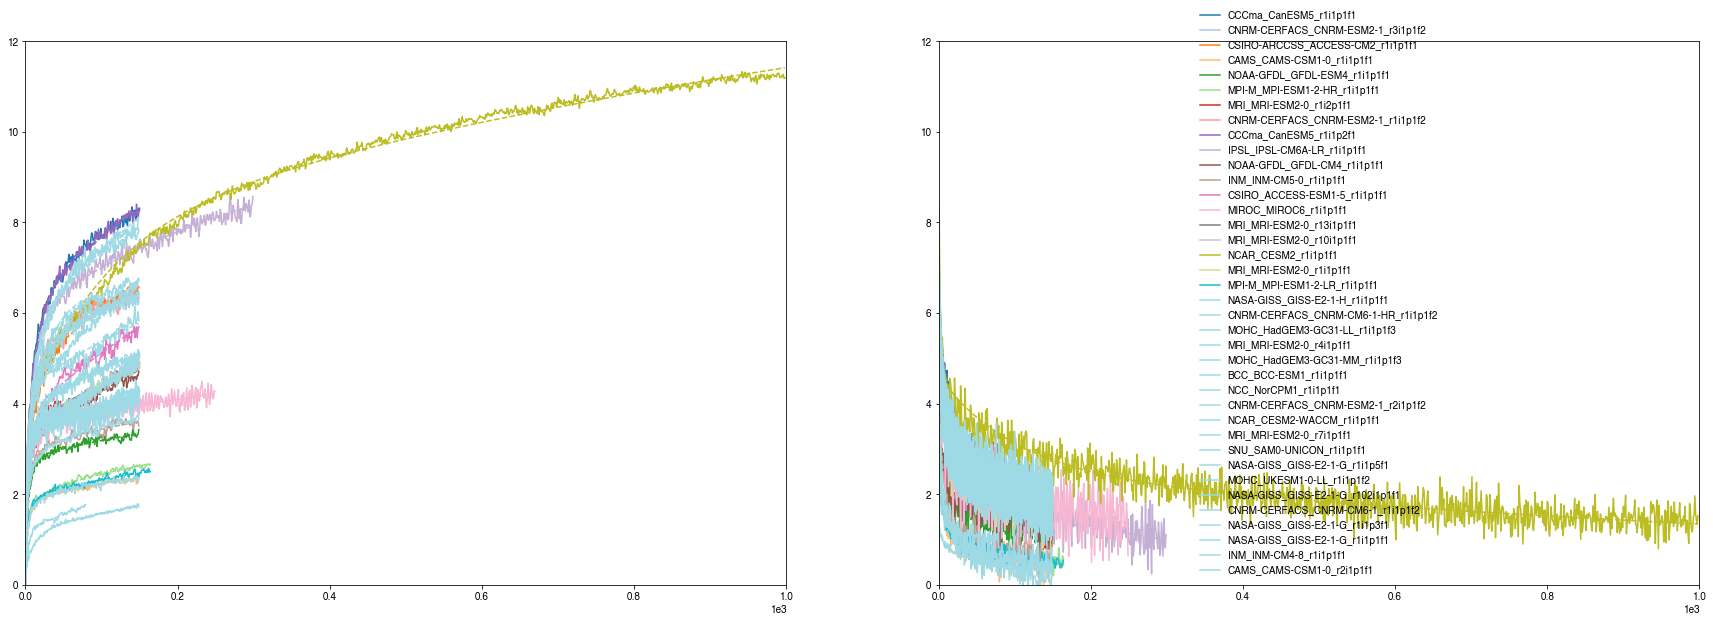

In [60]:
fig,ax = plt.subplots(1,2,figsize=(30,10))
cm = matplotlib.cm.tab20
i=0
for i,(ism,ism_fit) in enumerate(res_df.iteritems()):
    CMIP6_run = abrupt4x_tas_anom_df[ism].dropna().values
    A,b,Q,A_d,b_d,Q_d,gamma0,a0,C_d,u = BuildMat(ism_fit.values)
    w_d = sp.stats.multivariate_normal(mean = None , cov = Q_d, allow_singular=True)
    x = np.zeros((CMIP6_run.shape[0]+1,4))
    y = np.zeros((CMIP6_run.shape[0]+1,2))
    x[:,0] = ism_fit.loc['F_4x']
    y[0,:] = C_d @ x[0]
    for t in np.arange(x.shape[0]-1):
        x[t+1] = A_d@x[t]+b_d*ism_fit.loc['F_4x']
        y[t+1] = C_d@x[t]
    ax[0].plot(np.arange(CMIP6_run.shape[0]),y[1:,0],ls='--',c=cm(i/20))
    ax[0].plot(np.arange(CMIP6_run.shape[0]),CMIP6_run,c=cm(i/20),label=ism)
    ax[1].plot(np.arange(CMIP6_run.shape[0]),y[1:,1],ls='--',c=cm(i/20))
    ax[1].plot(np.arange(CMIP6_run.shape[0]),abrupt4x_EB_anom_df[ism].dropna().values,c=cm(i/20),label=ism)
    
ax[1].legend()
ax[0].set_xlim(0,1000)
ax[1].set_xlim(0,1000)
ax[0].set_ylim(0,12)
ax[1].set_ylim(0,12)

In [ ]:
##### fig,ax = plt.subplots(figsize=(20,10))
cm = matplotlib.cm.tab20
i=0
for i,(ism,ism_fit) in enumerate(res_df.loc[:,res_df.loc['success']==1].iteritems()):
    CMIP6_run = abrupt_4x_datasets[ism].temp.dropna().values
    A,b,Q,A_d,b_d,Q_d,gamma0,a0,C_d,u = BuildMat(ism_fit.values[:-4])
    x = np.zeros((CMIP6_run.size+1,4))
    x[:,0] = ism_fit.loc['F_4x']
    A_1 = A.copy()
    A_1[0,0] = 0
    A_d_1 = sp.linalg.expm(A_1)
    for t in np.arange(x.shape[0]-1):
        x[t+1] = A_d_1@x[t]
    plt.plot(np.arange(CMIP6_run.size),x[1:,1],ls='--',c=cm(i/20))
    plt.plot(np.arange(CMIP6_run.size),CMIP6_run,c=cm(i/20),label=ism)
    
plt.legend()
plt.xlim(0,1000)

In [79]:
res_df.iloc[:,0]

gamma       2.947677
C1          3.362683
C2         11.696042
C3         71.794155
kap1        0.646985
kap2        2.091349
kap3        0.610356
epsilon     1.089329
stds        0.574455
stdx        0.427683
F_4x        7.542052
Name: CCCma_CanESM5_r1i1p1f1, dtype: float64

In [67]:
A,b,Q,A_d,b_d,Q_d,gamma0,a0,C_d,u = BuildMat(res_df.iloc[:,0])

A

array([[-2.94767734,  0.        ,  0.        ,  0.        ],
       [ 0.29738163, -0.81433022,  0.6219289 ,  0.        ],
       [ 0.        ,  0.17880831, -0.23565481,  0.0568465 ],
       [ 0.        ,  0.        ,  0.00850148, -0.00850148]])

In [82]:
np.linalg.inv(np.linalg.eig(A[1:,1:])[1])

array([[ 0.85187199, -0.72534095,  0.0430373 ],
       [ 0.25295977,  1.02684853, -0.72978837],
       [ 0.02322864,  0.10534382,  1.17838206]])